In [1]:
using Distributions, TensorFlow
using Plots; pyplot()

Plots.PyPlotBackend()

In [2]:
# Generate some synthetic data
x = randn(100, 50)
w = randn(50, 10)
y_prob = exp(x * w)
y_prob ./= sum(y_prob, 2)

function draw(probs)
    y = zeros(size(probs))
    for i in 1:size(probs, 1)
        idx = rand(Categorical(probs[i,:]))
        y[i,idx] = 1
    end
    return y
end

y = draw(y_prob)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] exp(::Array{Float64,2}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:515
 [4] include_string(::Module, ::String, ::String) at /home/kai/.julia/v0.6/Compat/src/Compat.jl:407
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/kai/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] eventloop(::ZMQ.Socket) at /home/kai/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[2], in expression starting on line 4


100×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 ⋮                        ⋮                      
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0 

In [3]:
# Build the model
sess = Session()

X = placeholder(Float32)
Y_obs = placeholder(Float32)

W = Variable(randn(50, 10))
B = Variable(zeros(Float32, 10))

Y = nn.softmax(X * W + B)

loss = -reduce_sum(log(Y) .* Y_obs)
optimizer = train.AdamOptimizer()
minimize_op = train.minimize(optimizer, loss)
saver = train.Saver()

2017-09-15 12:52:28.632482: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-15 12:52:28.632498: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-15 12:52:28.632501: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-09-15 12:52:28.632503: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-15 12:52:28.632505: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

<Saver>

In [4]:
# Run training
run(sess, global_variables_initializer())

checkpoint_path = mktempdir(); loss_his = []

info("Checkpoint files saved in $checkpoint_path")
for epoch in 1:1000
    cur_loss, _ = run(sess, [loss, minimize_op], Dict(X=>x, Y_obs=>y))
    push!(loss_his, cur_loss)
    if epoch % 100 == 0
      println(@sprintf("Epoch %d; current loss is %.2f.", epoch, cur_loss))
      train.save(saver, sess, joinpath(checkpoint_path, "logistic"), global_step=epoch)
    end
end

INFO: Checkpoint files saved in /tmp/tmpXoBPhD


Epoch 100; current loss is 878.24.
Epoch 200; current loss is 692.79.
Epoch 300; current loss is 533.53.
Epoch 400; current loss is 402.77.
Epoch 500; current loss is 300.13.
Epoch 600; current loss is 221.25.
Epoch 700; current loss is 158.05.
Epoch 800; current loss is 109.41.
Epoch 900; current loss is 73.44.
Epoch 1000; current loss is 47.43.



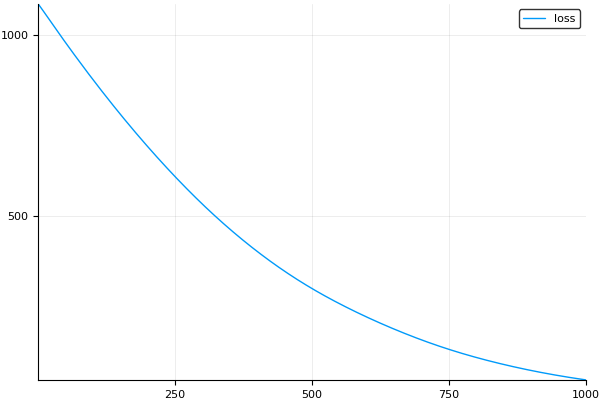

In [5]:
plot(loss_his, label="loss")